# Battle of the Neighborhoods
Finding the best Neighbourhood in Toronto using Data Science

In [1]:
# Imports 
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import json
import seaborn as sns
from bs4 import BeautifulSoup

#!pip install geopy
from geopy.geocoders import Nominatim 
# module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#! pip install folium==0.5.0
import folium # plotting library
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


This project aims to utilize all Data Science Concepts learned in the IBM Data Science Professional Course. We define a Business Problem, the data that will be utilized and using that data, we are able to analyze it using Machine Learning tools. In this project, we will go through all the processes in a step by step manner from problem designing, data preparation to final analysis and finally will provide a conclusion that can be leveraged by the business stakeholders to make their decisions.

Table of Contents
- Introduction
- Target Audience
- Data Overview
- Methodology
- Discussion
- Conclusion

# 1. Introduction 

Toronto is one of the most densely populated areas in Canada. Being the land of opportunity, it brings in a variety of people from different ethnic backgrounds to the core city of Canada, Toronto. Being the largest city in Canada with an estimated population of over 6 million, there is no doubt about the diversity of the population. Multiculturalism is seen through the various neighbourhoods including; Chinatown, Corso Italia, Little India, Kensington Market, Little Italy, Koreatown and many more. Downtown Toronto being the hub of interactions between ethnicities brings many opportunities for entrepreneurs to start or grow their business. It is a place where people can try the best of each culture, either while they work or just passing through. Toronto is well known for its great food.

The objective of this project is to use Foursquare location data and regional clustering of venue information to determine what might be the ‘best’ neighbourhood in Toronto to open a restaurant. Pizza and Pasta are one of the most bought dishes in Toronto originating from Italy. Toronto is the fourth largest home to Italians with a population of over 500k, there are numerous opportunities to open a new Italian restaurant. Through this project, we will find the most suitable location for an entrepreneur to open a new Italian restaurant in Toronto, Canada.

# 2. Target Audience 

This project is aimed towards Entrepreneurs or Business owners who want to open a new Italian Restaurant or grow their current business. The analysis will provide vital information that can be used by the target audience

# 3. Data Overview

The data that will be required will be a combination of CSV files that have been prepared for the purposes of the analysis from multiple sources which will provide the list of neighbourhoods in Toronto (via Wikipedia), the Geographical location of the neighbourhoods (via Geocoder package) and Venue data pertaining to Italian restaurants (via Foursquare). The Venue data will help find which neighbourhood is best suitable to open an Italian restaurant.

## 3.1 Data Aquisition 

### Source 1: Wikipedia Table

In [2]:
wiki = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
wikipedia_page = requests.get(wiki)
data_raw = pd.read_html(wikipedia_page.content, header=0)[0]

# Filter out all rows where no Borough is specified
df = data_raw[data_raw.Borough != 'Not assigned']
df = df.reset_index(drop=True)
df.head(10)

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [3]:
# lets find out how many neighborhoods in each borough
df.groupby('Borough').count()['Neighbourhood']

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
East York            5
Etobicoke           12
Mississauga          1
North York          24
Scarborough         17
West Toronto         6
York                 5
Name: Neighbourhood, dtype: int64

In [4]:
df.shape

(103, 3)

The Wikipedia site shown above provided almost all the information about the neighbourhoods. It included the postal code, borough and the name of the neighbourhoods present in Toronto. Since the data is not in a format that is suitable for analysis, scraping of the data was done from this site

### Source 2: Geographical Location Data 

The second source of data provided us with the Geographical coordinates of the neighbourhoods with the respective Postal Codes. Luckily for us, the file was in CSV format. 

In [5]:
geo_df = pd.read_csv('http://cocl.us/Geospatial_data')
geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Source 2.5: Preprocessing for Foursquare

In [6]:
# Group neighboorhoods with same postcode and merge with geo data
df_grouped = df.groupby(['Postal Code', 'Borough'])['Neighbourhood'].apply(lambda x: ', '.join(x))
df_grouped = df_grouped.reset_index()
df_grouped.rename(columns = {'Neighbourhood':'Neighborhood'}, inplace = True)
geo_merged = pd.merge(geo_df, df_grouped, on='Postal Code')
geo_merged.head()

,Postal Code,Latitude,Longitude,Borough,Neighborhood
0,M1B,43.806686,-79.194353,Scarborough,"Malvern, Rouge"
1,M1C,43.784535,-79.160497,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,43.763573,-79.188711,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,43.770992,-79.216917,Scarborough,Woburn
4,M1H,43.773136,-79.239476,Scarborough,Cedarbrae


In [7]:
# Deal only with 'Toronto' boroughs
toronto_data=geo_merged[geo_merged['Borough'].str.contains("Toronto")].reset_index()
toronto_data.head()
toronto_data.shape

(39, 6)

### Source 3: Venue Data using Foursquare

In [8]:
# Setup Credentials
CLIENT_ID = 'UYZ3VCDRXH4RA2MURESRFOIG2VGDURD2CYZZ3L04DTKW24YS'
CLIENT_SECRET = '2OGUFQ0L4VWWQC4JGQW5YVAHWEHSWW4EYSZ3BENKF4Z4RH55'
ACCESS_TOKEN = 'NJQIGWHH4IVOD1XU3N02EP3ZTHIJZNY2EAKLARDYIL2LDQCZ'
VERSION = '20180604'
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UYZ3VCDRXH4RA2MURESRFOIG2VGDURD2CYZZ3L04DTKW24YS
CLIENT_SECRET:2OGUFQ0L4VWWQC4JGQW5YVAHWEHSWW4EYSZ3BENKF4Z4RH55


In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
# Get nearby neighborhood locationss
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude'])

The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High 

In [11]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


# 4. Methodology

### 4.1 - Data Cleansing

After all the data was collected and put into data frames, cleansing and merging of the data was required to start the process of analysis. When getting the data from Wikipedia, there were Boroughs that were not assigned to any neighbourhood therefore, the following assumptions were made:

1. Only the cells that have an assigned a borough will be processed. Borough’s that were not assigned get ignored.
2. More than one neighbourhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighbourhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighbourhoods separated with a comma.
3. If a cell has a borough but a Not assigned neighbourhood, then the neighbourhood will be the same as the borough.

After the implementation of the following assumptions, the rows were grouped based on the borough as shown below.

In [12]:
df.head(3)

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Using the Latitude and Longitude collected from http://cocl.us/Geospatial_data ...


In [13]:
geo_df.head(3)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711


I merged the two tables together based on Postal Code which resulted in the below dataframe.

In [14]:
geo_merged.head(3)

,Postal Code,Latitude,Longitude,Borough,Neighborhood
0,M1B,43.806686,-79.194353,Scarborough,"Malvern, Rouge"
1,M1C,43.784535,-79.160497,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,43.763573,-79.188711,Scarborough,"Guildwood, Morningside, West Hill"


After, the venue data pulled from the Foursquare API was merged with the table above providing us with the local venue within a 500-meter radius shown below.


In [15]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


### 4.2 Data Exploration

Now after cleansing the data, the next step was to analyze it. We then created a map using Folium and colour-coded each Neighborhood depending on what Borough it was located in.

In [16]:
# Visualizing Toronto

address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [17]:
# create map of Toronto using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)
colors = ['red', 'blue', 'yellow', 'green']
brws = ['East Toronto', 'Central Toronto', 'Downtown Toronto', 'West Toronto']

# add neighborhood (borough) markers to map
for lat, lng, label, brw in zip( 
    toronto_data['Latitude'], 
    toronto_data['Longitude'],
    toronto_data['Neighborhood'],
    toronto_data['Borough']
    ):
    label = folium.Popup(label, parse_html=True)
    if brw == brws[0]:
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='green',
            fill=True,
            fill_color='green',
            fill_opacity=0.7,
            parse_html=False).add_to(map_manhattan)
    if brw == brws[1]:
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7,
            parse_html=False).add_to(map_manhattan)
    if brw == brws[2]:
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
            parse_html=False).add_to(map_manhattan)
    if brw == brws[3]:
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='yellow',
            fill=True,
            fill_color='yellow',
            fill_opacity=0.7,
            parse_html=False).add_to(map_manhattan)  

    
map_manhattan

Next, we used the Foursquare API to get a list of all the Venues in Toronto which included Parks, Schools, Café Shops, Asian Restaurants etc. Getting this data was crucial to analyzing the number of Italian Restaurants all over Toronto. There was a total of 45 Italian Restaurants in Toronto. We then merged the Foursquare Venue data with the Neighborhood data which then gave us the nearest Venue for each of the Neighborhoods.

In [18]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


### 4.3 Machine Learning 

Then to analyze the data we performed a technique in which Categorical Data is transformed into Numerical Data for Machine Learning algorithms. This technique is called One hot encoding. For each of the neighbourhoods, individual venues were turned into the frequency at how many of those Venues were located in each neighbourhood.

In [19]:
# one hot encoding
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()


(1618, 236)


,Neighborhoods,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,...,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [20]:
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(to_grouped.shape)
to_grouped.head()

(39, 236)


,Neighborhoods,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,...,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Berczy Park,0.0000,0.0000,0.000,0.000,0.000,0.0,0.0,0.0,0.016949,...,0.0,0.0,0.0,0.0,0.016949,0.0,0.0,0.000000,0.0,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.0000,0.0000,0.000,0.000,0.000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
2,"Business reply mail Processing Centre, South C...",0.0000,0.0000,0.000,0.000,0.000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.062500
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.0625,0.0625,0.125,0.125,0.125,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
4,Central Bay Street,0.0000,0.0000,0.000,0.000,0.000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.015873,0.0,0.0,0.015873,0.0,0.015873


In [21]:
ita = to_grouped[["Neighborhoods","Italian Restaurant"]]
ita.head() #.head() shows the first five rows only

,Neighborhoods,Italian Restaurant
0,Berczy Park,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.045455
2,"Business reply mail Processing Centre, South C...",0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000
4,Central Bay Street,0.047619


Now we will cluster the neighborhoods.

We will use k-means clustering. But first we will find the best K using the Elbow Point method.

In [22]:
ita = ita.rename(columns={'Neighborhoods':'Neighborhood'})

In [23]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = ita.drop(['Neighborhood'], axis=1)

In [24]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([1, 0, 1, 1, 0, 0, 1, 2, 0, 1])

In [25]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [26]:
scores = [get_inertia(x) for x in range(2, 21)]

Text(0, 0.5, 'Error')

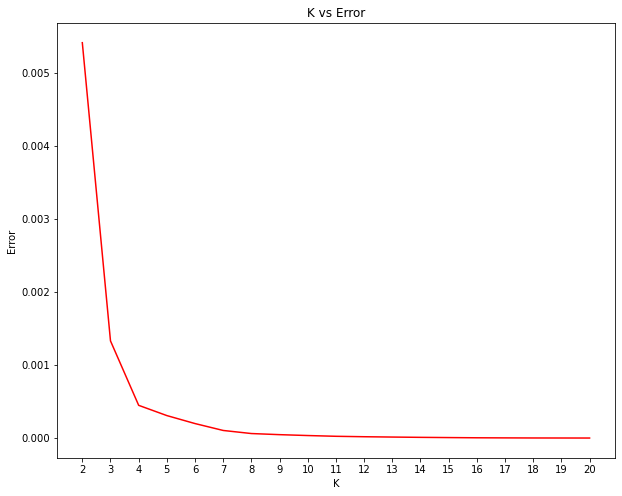

In [27]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")


We see that the optimum K value is 4 so we will have a resulting of 4 clusters

In [28]:
toronto_grouped_clustering = ita.drop('Neighborhood', 1)

# run k-means clustering
kclusters = 4
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 3, 0, 0, 3, 1, 0, 2, 1, 0])

In [29]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = ita.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [30]:
to_merged.head()

,Neighborhood,Italian Restaurant,Cluster Labels
0,Berczy Park,0.000000,0
1,"Brockton, Parkdale Village, Exhibition Place",0.045455,3
2,"Business reply mail Processing Centre, South C...",0.000000,0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0
4,Central Bay Street,0.047619,3


In [31]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(1618, 9)


,Neighborhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berczy Park,0.0,0,43.644771,-79.373306,The Keg Steakhouse + Bar - Esplanade,43.646712,-79.374768,Restaurant
0,Berczy Park,0.0,0,43.644771,-79.373306,LCBO,43.642944,-79.372440,Liquor Store
0,Berczy Park,0.0,0,43.644771,-79.373306,Fresh On Front,43.647815,-79.374453,Vegetarian / Vegan Restaurant
0,Berczy Park,0.0,0,43.644771,-79.373306,Meridian Hall,43.646292,-79.376022,Concert Hall
0,Berczy Park,0.0,0,43.644771,-79.373306,Berczy Park,43.648048,-79.375172,Park


In [32]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged

(1618, 9)


,Neighborhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berczy Park,0.000000,0,43.644771,-79.373306,The Keg Steakhouse + Bar - Esplanade,43.646712,-79.374768,Restaurant
11,"First Canadian Place, Underground city",0.010000,0,43.648429,-79.382280,The Burger's Priest,43.648643,-79.387539,Fast Food Restaurant
11,"First Canadian Place, Underground city",0.010000,0,43.648429,-79.382280,Ruby Thai (First Canadian Place),43.649091,-79.381600,Thai Restaurant
11,"First Canadian Place, Underground city",0.010000,0,43.648429,-79.382280,Astarté Fresh Yogurt Bar,43.647596,-79.386419,Café
11,"First Canadian Place, Underground city",0.010000,0,43.648429,-79.382280,Cosmopolitan Toronto Centre Hotel & Spa,43.649064,-79.377598,Hotel
...,...,...,...,...,...,...,...,...,...
30,"St. James Town, Cabbagetown",0.045455,3,43.667967,-79.367675,Kingyo Toronto,43.665895,-79.368415,Japanese Restaurant
30,"St. James Town, Cabbagetown",0.045455,3,43.667967,-79.367675,Murgatroid,43.667381,-79.369311,Restaurant
30,"St. James Town, Cabbagetown",0.045455,3,43.667967,-79.367675,F'Amelia,43.667536,-79.368613,Italian Restaurant
4,Central Bay Street,0.047619,3,43.657952,-79.387383,Thai Express,43.661630,-79.387340,Thai Restaurant


Lets check how many Italian Restaurant are there

In [33]:
to_merged['Venue Category'].value_counts()['Italian Restaurant']

40

We see that there are a total of 40 locations with Italian Restaurants in Toronto.

We will create a new dataframe with the Neighborhood and Italian Restaurants

In [34]:
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)
colors = ['red', 'blue', 'yellow', 'green']
brws = ['East Toronto', 'Central Toronto', 'Downtown Toronto', 'West Toronto']

# add neighborhood (borough) markers to map
for lat, lng, label, brw in zip(
    to_merged['Neighborhood Latitude'],
     to_merged['Neighborhood Longitude'],
      to_merged['Neighborhood'],
       to_merged['Cluster Labels']):

    label = folium.Popup(label, parse_html=True)
    if brw == 0:
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7,
            parse_html=False).add_to(map_manhattan)
    if brw == 1:
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='yellow',
            fill=True,
            fill_color='yellow',
            fill_opacity=0.7,
            parse_html=False).add_to(map_manhattan)
    if brw == 2:
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
            parse_html=False).add_to(map_manhattan)
    if brw == 3:
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='green',
            fill=True,
            fill_color='green',
            fill_opacity=0.7,
            parse_html=False).add_to(map_manhattan)  

map_manhattan

In [35]:
ita["Cluster Labels"] = kmeans.labels_
ita.head()

,Neighborhood,Italian Restaurant,Cluster Labels
0,Berczy Park,0.000000,0
1,"Brockton, Parkdale Village, Exhibition Place",0.045455,3
2,"Business reply mail Processing Centre, South C...",0.000000,0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0
4,Central Bay Street,0.047619,3


### 4.4 Data Analysis

We have a total of 4 clusters (0,1,2,3). Before we analyze them one by one let's check the total amount of neighbourhoods in each cluster. 

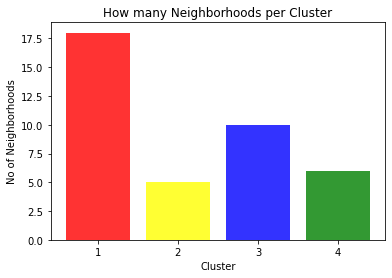

In [36]:
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = ita['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'yellow','blue', 'green'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

In [37]:
# How many neighborhoods in each cluster
ita['Cluster Labels'].value_counts()

0    18
2    10
3     6
1     5
Name: Cluster Labels, dtype: int64

From the bar graph that was made using Matplotlib, we can compare the number of Neighborhoods per Cluster. We see that Cluster 1 has 18 neighborhoods while cluster 2 has 10 neighborhoods (second most). Cluster 4 has 8 neighbourhoods and cluster 3 has only 6. 

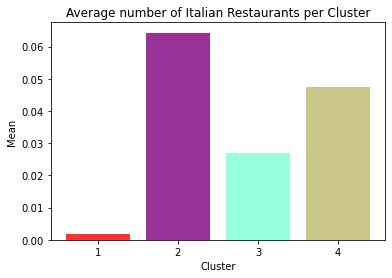

In [56]:
clusters_mean = [df_cluster1['Italian Restaurant'].mean(),df_cluster2['Italian Restaurant'].mean(),df_cluster3['Italian Restaurant'].mean(),
                 df_cluster4['Italian Restaurant'].mean()]
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Italian Restaurants per Cluster')

plt.show()

Then we compared the average Italian Restaurants per cluster. From the bar graph that was made using Matplotlib, we can compare the the average Italian Restaurants per cluster. We see that Cluster 1 has the least italian restaurants while cluster 2 has the most. Cluster 3 has around half the number of italian restaurants as cluster 4. 

### Cluster Analysis

In [39]:
df.head(3)

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"


This information is crucial as we can see that even though there is only 1 Italian restaurant in Cluster 1, it has the highest number of neighborhoods (0.1304) while Cluster 2 has the least neighborhoods but has the highest average of Italian Restaurants (0.0009). Also, from the map, we can see that neighborhoods in Cluster 2 are the most sparsely populated. Now let us analyze the clusters one by one.

#### Cluster 1: Red

Cluster 1 was mainly in the East Toronto Area. First Canadian Place, Underground city, Richmond, Adelaide, King were among some neighborhoods that were in that cluster. Cluster 1 had 173 unique Venue locations and out of those only 1 were Italian Restaurants. Cluster 1 had the lowest average of Italian Restaurants equating to 0.0. 

In [40]:
#  This will create a dataframe with borough of each neighborhood 
#  which we will merge with each cluster dataframe
df_new = df[['Borough', 'Neighbourhood']]
df_new.rename(columns = {'Neighbourhood':'Neighborhood'}, inplace = True)

# Red
cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')
df_cluster1.head(3)

,Borough,Neighborhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,East Toronto,The Beaches,0.0,0,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,East Toronto,The Beaches,0.0,0,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,East Toronto,The Beaches,0.0,0,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub


In [41]:
df_cluster1[['Venue Category']].value_counts()

Venue Category    
Coffee Shop           40
Café                  25
Restaurant            17
Park                  13
Sushi Restaurant      12
                      ..
Italian Restaurant     1
Jewelry Store          1
Knitting Store         1
Korean Restaurant      1
Airport                1
Length: 173, dtype: int64

In [42]:
df_cluster1.Neighborhood.value_counts()

First Canadian Place, Underground city                                                                        100
Richmond, Adelaide, King                                                                                       95
Church and Wellesley                                                                                           80
Kensington Market, Chinatown, Grange Park                                                                      65
Berczy Park                                                                                                    59
The Annex, North Midtown, Yorkville                                                                            19
North Toronto West, Lawrence Park                                                                              18
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport     16
Business reply mail Processing Centre, South Central Letter Processing Plant Toronto    

In [43]:
df_cluster1.Borough.value_counts()

Downtown Toronto    419
Central Toronto      75
East Toronto         20
West Toronto         15
Name: Borough, dtype: int64

#### Cluster 2

There was a total of 140 neighbourhoods, 63 different venues and 9 Italian Restaurants. Therefore,the average amount of Italian Restaurants that were near the venues in Cluster 2 is the highest being 0.07. In the map and from our numbers, we can see that nodes of Cluster 2 were dispersed mostly evenly throughout Toronto making it one of the most sparsely populated clusters.

In [44]:
# Yellow 
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')
df_cluster2.sort_values(["Italian Restaurant"], ascending=False).head(3)

,Borough,Neighborhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
70,West Toronto,"Parkdale, Roncesvalles",0.071429,1,43.64896,-79.456325,Butler's Pantry,43.650087,-79.450458,Breakfast Spot
65,West Toronto,"Parkdale, Roncesvalles",0.071429,1,43.64896,-79.456325,Revue Cinema,43.651112,-79.450961,Movie Theater
58,West Toronto,"Parkdale, Roncesvalles",0.071429,1,43.64896,-79.456325,Aris Grill,43.650091,-79.450396,Breakfast Spot


In [45]:
df_cluster2[['Venue Category']].value_counts()

Venue Category             
Café                           11
Greek Restaurant                9
Italian Restaurant              9
Coffee Shop                     8
Dessert Shop                    6
                               ..
Frozen Yogurt Shop              1
French Restaurant               1
Farmers Market                  1
Eastern European Restaurant     1
American Restaurant             1
Length: 63, dtype: int64

In [46]:
df_cluster2.Neighborhood.value_counts()

The Danforth West, Riverdale      43
Davisville                        35
University of Toronto, Harbord    33
Christie                          15
Parkdale, Roncesvalles            14
Name: Neighborhood, dtype: int64

In [47]:
df_cluster2.Borough.value_counts()

Downtown Toronto    48
East Toronto        43
Central Toronto     35
West Toronto        14
Name: Borough, dtype: int64

#### Cluster 3

Cluster 3 had the second to lowest average of Italian Restaurants. Cluster 3 was mainly located in the Downtown area but also had some neighbourhoods in West Toronto, East Toronto and in North York. Neighbourhoods such as Ryerson, Toronto Dominion Center, Garden District, Queen’s Park and many more were included in this cluster. There was a total of 162 unique venues and out of those 20 were Italian Restaurants.

In [48]:
# Blue
cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')
df_cluster3.head(3)

,Borough,Neighborhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Downtown Toronto,"Regent Park, Harbourfront",0.022222,2,43.65426,-79.360636,The Abnormal Beauty Company,43.649892,-79.361005,Cosmetics Shop
1,Downtown Toronto,"Regent Park, Harbourfront",0.022222,2,43.65426,-79.360636,Izumi,43.649970,-79.360153,Asian Restaurant
2,Downtown Toronto,"Regent Park, Harbourfront",0.022222,2,43.65426,-79.360636,Vistek,43.657046,-79.359667,Electronics Store


In [49]:
df_cluster3[['Venue Category']].value_counts()

Venue Category     
Coffee Shop            79
Café                   33
Hotel                  26
Restaurant             22
Italian Restaurant     20
                       ..
Convenience Store       1
Indie Movie Theater     1
Comic Shop              1
General Travel          1
Hobby Shop              1
Length: 162, dtype: int64

In [50]:
df_cluster3.Neighborhood.value_counts()

Garden District, Ryerson                             100
Harbourfront East, Union Station, Toronto Islands    100
Commerce Court, Victoria Hotel                       100
Toronto Dominion Centre, Design Exchange             100
Stn A PO Boxes                                        98
St. James Town                                        80
Regent Park, Harbourfront                             45
Little Portugal, Trinity                              43
Studio District                                       37
Queen's Park, Ontario Provincial Government           35
Name: Neighborhood, dtype: int64

In [51]:
df_cluster3.Borough.value_counts()

Downtown Toronto    658
West Toronto         43
East Toronto         37
Name: Borough, dtype: int64

#### Cluster 4

Cluster 4 venues were located in the Downtown, West, East Toronto areas. Neighbourhoods such as Central Bay Street, St. James Town, Cabbagetownwere some of the neighbourhoods that made up this cluster. There were a total of 91 unique Venues in Cluster 4 with 10 Italian Restaurants. This made up the second-highest average of Italian Restaurants in that cluster which was approximately 0.047.

In [52]:
# Green
cluster4 = to_merged.loc[to_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighborhood')
df_cluster4.head(3)

,Borough,Neighborhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Downtown Toronto,Central Bay Street,0.047619,3,43.657952,-79.387383,The Elm Tree Restaurant,43.657397,-79.383761,Modern European Restaurant
1,Downtown Toronto,Central Bay Street,0.047619,3,43.657952,-79.387383,The Queen and Beaver Public House,43.657472,-79.383524,Gastropub
2,Downtown Toronto,Central Bay Street,0.047619,3,43.657952,-79.387383,College Park Area,43.659453,-79.383785,Park


In [53]:
df_cluster4[['Venue Category']].value_counts()

Venue Category       
Coffee Shop              21
Café                     13
Italian Restaurant       10
Pizza Place               6
Sushi Restaurant          6
                         ..
Performing Arts Venue     1
Electronics Store         1
Donut Shop                1
Pharmacy                  1
Antique Shop              1
Length: 91, dtype: int64

In [54]:
df_cluster4.Neighborhood.value_counts()

Central Bay Street                              63
St. James Town, Cabbagetown                     44
Runnymede, Swansea                              38
High Park, The Junction South                   24
Brockton, Parkdale Village, Exhibition Place    22
India Bazaar, The Beaches West                  20
Name: Neighborhood, dtype: int64

In [55]:
df_cluster4.Borough.value_counts()

Downtown Toronto    107
West Toronto         84
East Toronto         20
Name: Borough, dtype: int64

# 5. Discussion 

Most of the Italian Restaurants are in cluster 2 represented by the yellow clusters. The Neighborhoods located in the East Toronto area that have the highest average of Italian Restaurants are The Danforth West and Riverdale. Even though there is a huge number of Neighborhoods in cluster 1, there is little to no Italian Restaurant. We see that in the Downtown Toronto area (cluster 3) has the second last average of Italian Restaurants. Looking at the nearby venues, the optimum place to put a new Italian Restaurant in cluster 1 as there are many Neighborhoods in the area but little to no Italian Restaurants, therefore, eliminating any competition. The second-best Neighborhoods that have a great opportunity would be in areas such as which is in Cluster 4. Having 90 neighbourhoods in the area with 10 Italian Restaurants gives a good opportunity for opening a new restaurant, relative to cluster 3 where there are more neighborhoods and more italian restaurants.

Some of the drawbacks of this analysis are — the clustering is completely based on data obtained from the Foursquare API. Also, the analysis does not take into consideration of the Italian population across neighbourhoods as this can play a huge factor while choosing which place to open a new Italian restaurant. 

This concludes the optimal findings for this project and recommends the entrepreneur to open an authentic Italian restaurant in these locations such as Cluster 1 and can expect little to no competition.

# 6. Conclusion

In conclusion, to end off this project, we had an opportunity on a business problem, and it was tackled in a way that it was similar to how a genuine data scientist would do. We utilized numerous Python libraries to fetch the information, control the content and break down and visualize those datasets. We have utilized Foursquare API to investigate the settings in neighbourhoods of Toronto, get a great measure of data from Wikipedia which we scraped with the Beautifulsoup Web scraping Library. We also visualized utilizing different plots present in seaborn and Matplotlib libraries. Similarly, we applied AI strategy to anticipate the error given the information and utilized Folium to picture it on a map.

Places that have room for improvement or certain drawbacks give us that this project can be additionally improved with the assistance of more information and distinctive Machine Learning strategies. Additionally, we can utilize this venture to investigate any situation, for example, opening an alternate cuisine or opening of a Movie Theater and so forth. Ideally, this task acts as an initial direction to tackle more complex real-life problems using data science.